In [1]:
import os, argparse, pickle, librosa
from scipy.io.wavfile import write
from scipy.io import savemat
import matplotlib.pyplot as plt
import torch
from glob import glob
from eval_utils import *
import models
import IPython.display as ipd
from tqdm import tqdm
from params import get_arg

In [2]:
config = get_arg(['--future', '--diff', '--split_number', '100', '--mode', 'regr'])

SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [3]:
ABSpath = '/home/skuser/'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'datasets/hyundai')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = pickle.load(open(os.path.join(data_path,'stationary_accel_data.pickle'),'rb'))
sound_raw_data = pickle.load(open(os.path.join(data_path,'stationary_sound_data.pickle'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False

In [4]:
dataset = testDataset(accel_raw_data, sound_raw_data, config)

name = f'CombineAutoencoder_sj_S_b{config.b}_d{config.len}_lat{config.latency}_adam_0.001_decay0.7071_featurewav'
if config.future:
    name += '_future'
if config.diff:
    name += f'_diff_weight{config.loss_weight}'
if config.subtract:
    name += f'_subtract'
print(name)
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name + '/*')), key=lambda x: float(os.path.basename(x).split('.pt')[0].split('_')[-1]))[0]
if config.feature == 'wav':
    model = getattr(models, config.model)(dataset[0][0].shape[1:], dataset[0][1].shape[1:], dataset[0][0].shape[0], dataset[0][1].shape[0], config).to(device)
elif config.feature == 'mel':
    model = getattr(models, config.model)((config.nmels, 12), (config.len,), (config.len + config.b) // (config.nfft // 2) + 1, 8, config).to(device)

CombineAutoencoder_sj_S_b200_d200_lat5_adam_0.001_decay0.7071_featurewav_future_diff_weight0.5_subtract


In [5]:
print(modelsavepath)
model.load_state_dict(torch.load(modelsavepath)['model'])
dataset_generator = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

/home/skuser/ai_model/pytorch/test_model/model_save/CombineAutoencoder_sj_S_b200_d200_lat5_adam_0.001_decay0.7071_featurewav_future_diff_weight0.5_subtract/18_0.9083.pt


In [6]:

data_res, sound_res = [], []
model.eval()
with torch.no_grad():
    for data, sound in tqdm(dataset_generator):
#         data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu()[:,0,:])
        res = conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu()
        data_res.append(dataset.split(res, config.len // 2 - (config.split_number // 2), config.len // 2 + (config.split_number // 2)))
#         data_res.append(res[:,(config.len // 2) - (config.split_number // 2):(config.len // 2) + (config.split_number // 2)])

#         data_res.append(res[:, config.len // 2:])
        sound_res.append(sound)


100%|██████████| 6577/6577 [00:38<00:00, 168.89it/s]


In [7]:
from time import time
with torch.no_grad():
    for data, sound in dataset_generator:
        st= time()
        model(data[:1].to(device))
        print(time() - st)
        break

0.0012671947479248047


In [8]:
del dataset

In [9]:
start_time = config.b+config.len+config.latency+(config.len // 2)-config.split_number
len(sound) - start_time, len(sound_res)

(-373, 6577)

In [10]:
data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)

data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))

In [11]:

data_res = - data_res

In [12]:
# 새로 학습시킨 건 이 코드 제외
# data_res = data_res[200:]
# sound_res = sound_res[:-200]

<Figure size 432x288 with 0 Axes>

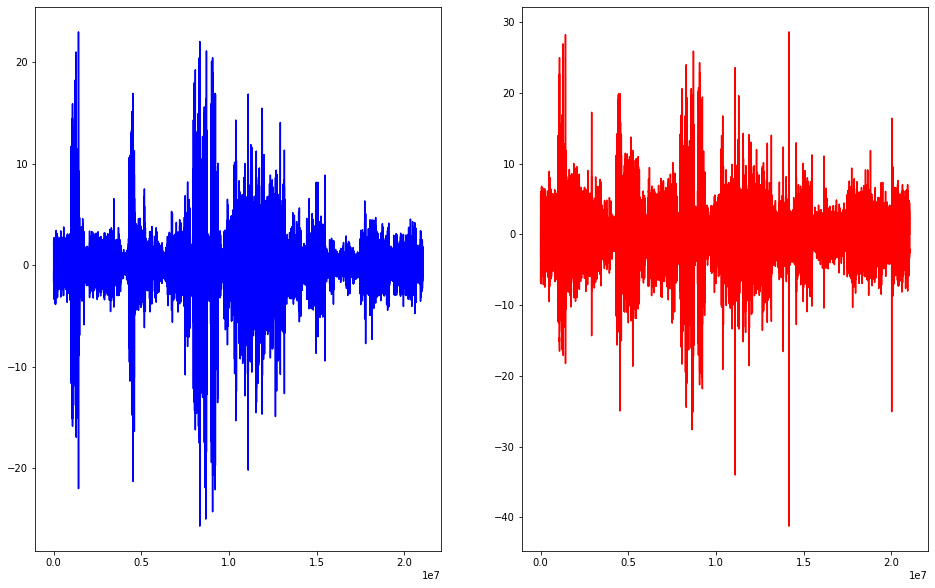

In [13]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(np.arange(data_res.size(0)), data_res[:,0], color="blue")
ax_lst[1].plot(np.arange(sound_res.size(0)), sound_res[:,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])

<Figure size 432x288 with 0 Axes>

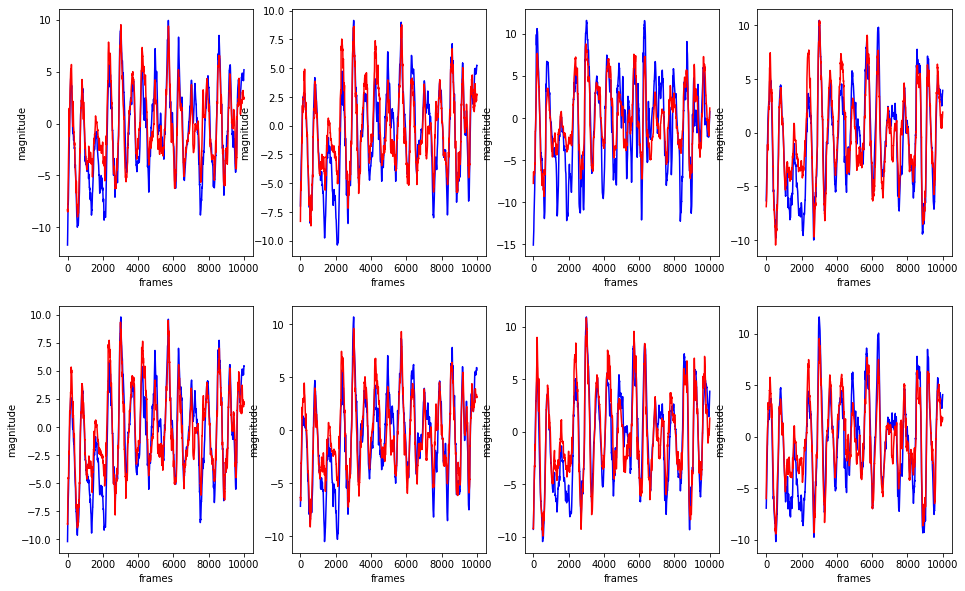

In [33]:
start = 1000000
end = 1010000
fig = plt.figure()
fig, sub = plt.subplots(2,4,figsize=(16,10))
for ax in sub.flat:
    ax.set(xlabel='frames', ylabel='magnitude')
for i in range(sound_res.shape[-1]):
    
    sub[i % 2][i // 2].plot(sound_res[start:end,i], color="blue")
    sub[i % 2][i // 2].plot(data_res[start:end,i], color="red")
# ax.plot(sound_res[start:end,0] - data_res[start:end,0], color='green')

# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

<Figure size 432x288 with 0 Axes>

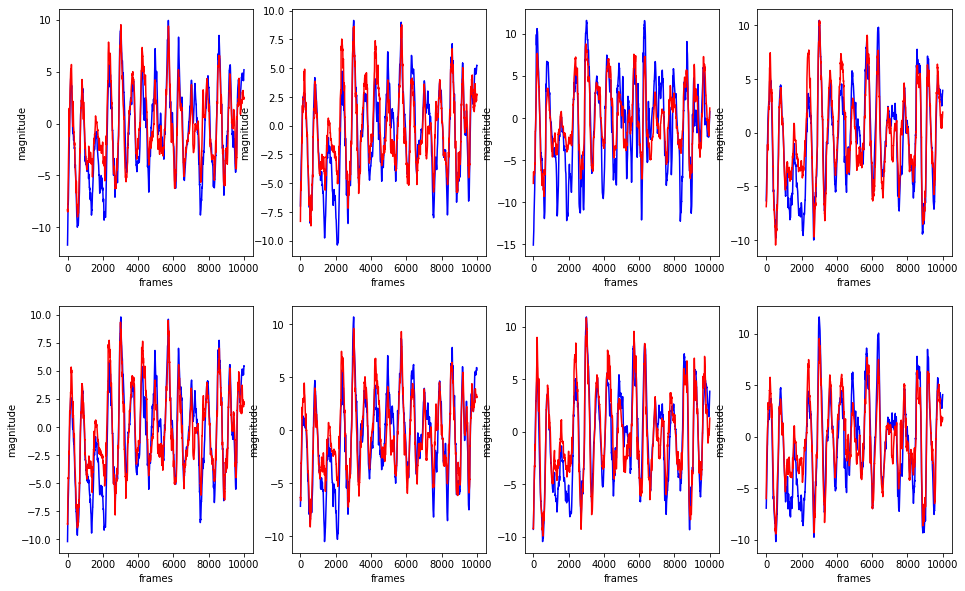

In [32]:
start = 1490000
end = 1500000
# start = 1000000
# end = 1010000
fig = plt.figure()
fig, sub = plt.subplots(2,4,figsize=(16,10))
for ax in sub.flat:
    ax.set(xlabel='frames', ylabel='magnitude')
for i in range(sound_res.shape[-1]):
    
    sub[i % 2][i // 2].plot(sound_res[start:end,i], color="blue")
    sub[i % 2][i // 2].plot(data_res[start:end,i], color="red")
# ax.plot(sound_res[start:end,0] - data_res[start:end,0], color='green')

# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

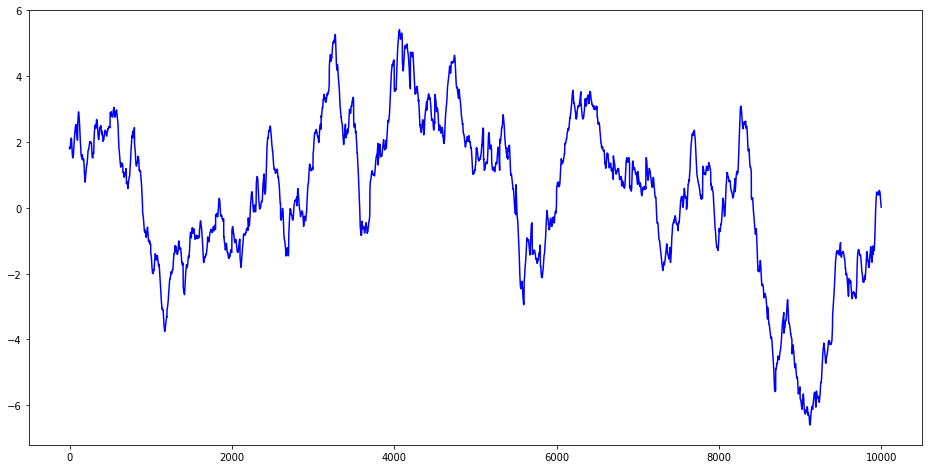

In [15]:
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(sound_res[start:end,0] - data_res[start:end,0], color="blue")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

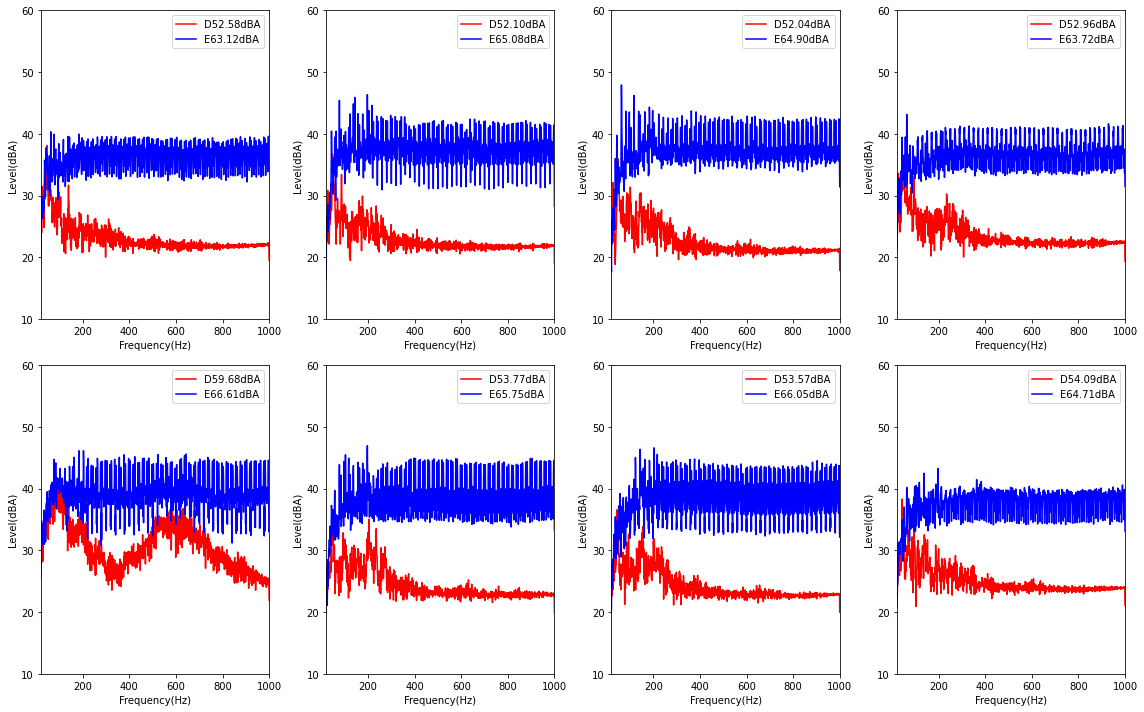

(-11.142537908442689, 64.99239975681135)

In [16]:
dBA_metric(data_res[1000000:1010000], sound_res[1000000:1010000] ,True)

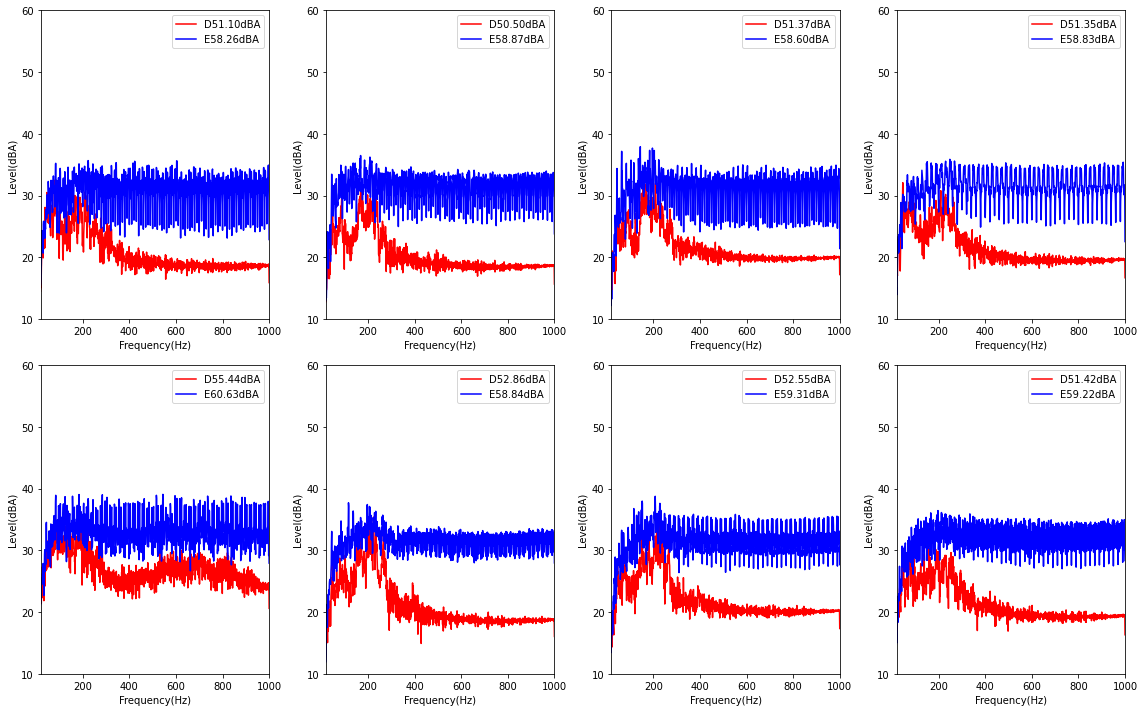

(-6.99530306001226, 59.06940589363582)

In [17]:
dBA_metric(data_res[start:end], sound_res[start:end] ,True)

In [26]:
a = (sound_res[1490000:1500000] - data_res[1490000:1500000]) ** 2
b = (a.mean(dim=0)).numpy()
print(b)
print(b.mean())
print('----------------------------------------------------------')
a = (sound_res[1000000:1010000] - data_res[1000000:1010000]) ** 2
b = (a.mean(dim=0)).numpy()
print(b)
print(b.mean())

[ 5.78405361  5.49556489  7.39013192  5.85244231 12.04781432  5.29358599
  7.12338899  5.6483204 ]
6.829412804466607
----------------------------------------------------------
[ 3.73630949  3.3042331   3.91214723  3.83961942 10.09052732  3.73879242
  4.12178195  3.66894733]
4.551544783553628


In [19]:
def write_wav(data, sr=8192, name='test_gen'):
    data = data.type(torch.float32).numpy()
    data = data - np.min(data)
    data /= np.max(data)
    write(name+'.wav', sr, data)
    return data


In [20]:
write_wav(sound_res[start:end,0], name='original')

array([0.55738646, 0.5558027 , 0.5559551 , ..., 0.4702843 , 0.4663384 ,
       0.4622772 ], dtype=float32)

In [21]:
write_wav(sound_res[start:end,0] - data_res[start:end,0])

array([0.7007602 , 0.6983573 , 0.6980068 , ..., 0.55610406, 0.5537962 ,
       0.55113876], dtype=float32)

In [22]:
ipd.Audio('test_gen.wav',normalize=False) # load a local WAV file

In [23]:
ipd.Audio('original.wav',normalize=False) # load a local WAV file